# Welcome to the Fashion-MNIST Challenge!

Website reference: https://github.com/zalandoresearch/fashion-mnist

In [1]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt


##################################################
# Params
##################################################

DATA_BASE_FOLDER = '/Users/jiaweima/jup/ML/project/image-classification-fashion-mnist'

# Dataset

The dataset contains 50k train + 10k validation images of 10 different categories ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot').

Each image is a 28x28 grayscale, and for simplicity here is flattened into a 784 dimensional vector.

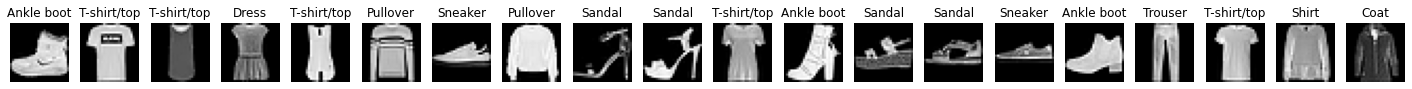

In [2]:
##################################################
# Load dataset
##################################################

x_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train.npy'))
x_valid = np.load(os.path.join(DATA_BASE_FOLDER, 'validation.npy'))
x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy'))
y_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))['class'].values
y_valid = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))['class'].values
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot random images of different classes
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [34]:
a = torch.Tensor([1,2,3])
y = torch.zeros(10)
y[int(a[2])]=1
print(y)

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


In [3]:
##################################################
# Process the data here, if needed
##################################################

'''
Any manipulation of the dataset in order to feed the data to the algorithm in the correct "format".
'''

import sys
sys.path.append('/Users/jiaweima/jup/ML/project/AG-CNN-master')

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from PIL import Image
import torchvision.transforms as transforms

N_CLASSES = len(y_labels)
class FashionDataset(Dataset):
    def __init__(self, dataset, labels, transforms=None): #numpy datasets and labels
        self.dataset = torch.FloatTensor(dataset) 
        self.labels = torch.FloatTensor(labels)
        self.transform = transforms
        
    def __getitem__(self, i):
        imag_rgb = torchvision.transforms.ToPILImage()(self.dataset[i]).convert('RGB')
        if self.transform is not None:
            imag = self.transform(imag_rgb)
        label = torch.zeros(N_CLASSES)
        label[int(self.labels[i])] = 1
        return imag, label
    
    def __len__(self):
        return len(self.dataset)

x_train = x_train.reshape(x_train.shape[0], 28, 28) # reconstruct immagines
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28)

TrainDataset = FashionDataset(x_train, y_train, transforms.Compose([transforms.Resize(256),
                                                                    transforms.CenterCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                         std=[0.229, 0.224, 0.225]),
                                                                    ]))
ValDataset = FashionDataset(x_valid, y_valid, transforms.Compose([transforms.Resize(256),
                                                                    transforms.CenterCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                         std=[0.229, 0.224, 0.225]),
                                                                    ]))

BATCH_SIZE = 32
train_loader = DataLoader(dataset=TrainDataset, batch_size=BATCH_SIZE,
                            shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=ValDataset, batch_size=128,
                            shuffle=False, pin_memory=True)


# Model

Here you have to implement a model (or more models, for finding the most accurate) for classification.

You can use the [`sklearn`](https://scikit-learn.org/stable/) (or optionally other more advanced frameworks such as [`pytorch`](https://pytorch.org/) or [`tensorflow`](https://www.tensorflow.org/)) package that contains a pool of models already implemented that perform classification. (SVMs, NNs, LR, kNN, ...)

In [ ]:
https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate #!!!!!!!!!!!!!!!!!!

In [6]:
##################################################
# Implement you model here
##################################################
import cv2
import time
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
from sklearn.metrics import roc_auc_score
from skimage.measure import label
from model import Densenet121_AG, Fusion_Branch
from PIL import Image

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((256,256)),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize,
])
def Attention_gen_patchs(ori_image, fm_cuda):
    # feature map -> feature mask (using feature map to crop on the original image) -> crop -> patchs
    feature_conv = fm_cuda.data.cpu().numpy()
    size_upsample = (224, 224) 
    bz, nc, h, w = feature_conv.shape

    patchs_cuda = torch.FloatTensor() #.cuda()

    for i in range(0, bz):
        feature = feature_conv[i]
        cam = feature.reshape((nc, h*w))
        cam = cam.sum(axis=0)
        cam = cam.reshape(h,w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)

        heatmap_bin = binImage(cv2.resize(cam_img, size_upsample))
        heatmap_maxconn = selectMaxConnect(heatmap_bin)
        heatmap_mask = heatmap_bin * heatmap_maxconn

        ind = np.argwhere(heatmap_mask != 0)
        minh = min(ind[:,0])
        minw = min(ind[:,1])
        maxh = max(ind[:,0])
        maxw = max(ind[:,1])
        
        # to ori image 
        image = ori_image[i].numpy().reshape(224,224,3)
        image = image[int(224*0.334):int(224*0.667),int(224*0.334):int(224*0.667),:]

        image = cv2.resize(image, size_upsample)
        image_crop = image[minh:maxh,minw:maxw,:] * 256 # because image was normalized before
        image_crop = preprocess(Image.fromarray(image_crop.astype('uint8')).convert('RGB')) 

        img_variable = torch.autograd.Variable(image_crop.reshape(3,224,224).unsqueeze(0)) #.cuda())

        patchs_cuda = torch.cat((patchs_cuda,img_variable),0)

    return patchs_cuda


def binImage(heatmap):
    _, heatmap_bin = cv2.threshold(heatmap , 0 , 255 , cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # t in the paper
    #_, heatmap_bin = cv2.threshold(heatmap , 178 , 255 , cv2.THRESH_BINARY)
    return heatmap_bin


def selectMaxConnect(heatmap):
    labeled_img, num = label(heatmap, connectivity=2, background=0, return_num=True)    
    max_label = 0
    max_num = 0
    for i in range(1, num+1):
        if np.sum(labeled_img == i) > max_num:
            max_num = np.sum(labeled_img == i)
            max_label = i
    lcc = (labeled_img == max_label)
    if max_num == 0:
       lcc = (labeled_img == -1)
    lcc = lcc + 0
    return lcc 

def test(model_global, model_local, model_fusion, test_loader):

    # initialize the ground truth and output tensor
    gt = torch.FloatTensor() #.cuda()
    pred_global = torch.FloatTensor() #.cuda()
    pred_local = torch.FloatTensor() #.cuda()
    pred_fusion = torch.FloatTensor() #.cuda()

    # switch to evaluate mode
    model_global.eval()
    model_local.eval()
    model_fusion.eval()
    cudnn.benchmark = True

    for i, (inp, target) in enumerate(test_loader):
        with torch.no_grad():
            if i % 2000 == 0:
                print('testing process:',i)
            target = target #.cuda()
            gt = torch.cat((gt, target), 0)
            input_var = torch.autograd.Variable(inp) #.cuda())
            #output = model_global(input_var)

            output_global, fm_global, pool_global = model_global(input_var)
            
            patchs_var = Attention_gen_patchs(inp,fm_global)

            output_local, _, pool_local = model_local(patchs_var)

            output_fusion = model_fusion(pool_global,pool_local)

            pred_global = torch.cat((pred_global, output_global.data), 0)
            pred_local = torch.cat((pred_local, output_local.data), 0)
            pred_fusion = torch.cat((pred_fusion, output_fusion.data), 0)
            
    AUROCs_g = compute_AUCs(gt, pred_global)
    AUROC_avg = np.array(AUROCs_g).mean()
    print('Global branch: The average AUROC is {AUROC_avg:.3f}'.format(AUROC_avg=AUROC_avg))
    for i in range(N_CLASSES):
        print('The AUROC of {} is {}'.format(CLASS_NAMES[i], AUROCs_g[i]))

    AUROCs_l = compute_AUCs(gt, pred_local)
    AUROC_avg = np.array(AUROCs_l).mean()
    print('\n')
    print('Local branch: The average AUROC is {AUROC_avg:.3f}'.format(AUROC_avg=AUROC_avg))
    for i in range(N_CLASSES):
        print('The AUROC of {} is {}'.format(CLASS_NAMES[i], AUROCs_l[i]))

    AUROCs_f = compute_AUCs(gt, pred_fusion)
    AUROC_avg = np.array(AUROCs_f).mean()
    print('\n')
    print('Fusion branch: The average AUROC is {AUROC_avg:.3f}'.format(AUROC_avg=AUROC_avg))
    for i in range(N_CLASSES):
        print('The AUROC of {} is {}'.format(CLASS_NAMES[i], AUROCs_f[i]))


def compute_AUCs(gt, pred):
    """Computes Area Under the Curve (AUC) from prediction scores.

    Args:
        gt: Pytorch tensor on GPU, shape = [n_samples, n_classes]
          true binary labels.
        pred: Pytorch tensor on GPU, shape = [n_samples, n_classes]
          can either be probability estimates of the positive class,
          confidence values, or binary decisions.

    Returns:
        List of AUROCs of all classes.
    """
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs


LR_G = 1e-8
LR_L = 1e-8
LR_F = 1e-3
num_epochs = 3
BATCH_SIZE = 32

# initialize and load the model
Global_Branch_model = Densenet121_AG(pretrained = False, num_classes = N_CLASSES) #.cuda()
Local_Branch_model = Densenet121_AG(pretrained = False, num_classes = N_CLASSES) #.cuda()
Fusion_Branch_model = Fusion_Branch(input_size = 2048, output_size = N_CLASSES) #.cuda()
cudnn.benchmark = True
criterion = nn.BCELoss()

optimizer_global = optim.Adam(Global_Branch_model.parameters(), lr=LR_G, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
lr_scheduler_global = lr_scheduler.StepLR(optimizer_global , step_size = 10, gamma = 1)

optimizer_local = optim.Adam(Local_Branch_model.parameters(), lr=LR_L, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
lr_scheduler_local = lr_scheduler.StepLR(optimizer_local , step_size = 10, gamma = 1)

optimizer_fusion = optim.Adam(Fusion_Branch_model.parameters(), lr=LR_F, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
lr_scheduler_fusion = lr_scheduler.StepLR(optimizer_fusion , step_size = 15, gamma = 0.1)

print('********************load model succeed!********************')


print('********************begin training!********************')
for epoch in range(num_epochs):
    since = time.time()
    print('Epoch {}/{}'.format(epoch , num_epochs - 1))
    print('-' * 10)
    #set the mode of model
    lr_scheduler_global.step()  #about lr and gamma
    lr_scheduler_local.step() 
    lr_scheduler_fusion.step() 
    Global_Branch_model.train()  #set model to training mode
    Local_Branch_model.train()
    Fusion_Branch_model.train()

    running_loss = 0.0
    #Iterate over data
    for i, (input, target) in enumerate(train_loader):
        input_var = torch.autograd.Variable(input) #.cuda())
        target_var = torch.autograd.Variable(target) #.cuda())
        optimizer_global.zero_grad()
        optimizer_local.zero_grad()
        optimizer_fusion.zero_grad()

        # compute output
        output_global, fm_global, pool_global = Global_Branch_model(input_var)

        patchs_var = Attention_gen_patchs(input,fm_global)

        output_local, _, pool_local = Local_Branch_model(patchs_var)
        #print(fusion_var.shape)
        output_fusion = Fusion_Branch_model(pool_global, pool_local)
        #

        # loss
        loss1 = criterion(output_global, target_var)
        loss2 = criterion(output_local, target_var)
        loss3 = criterion(output_fusion, target_var)
        #

        loss = loss1*0.8 + loss2*0.1 + loss3*0.1 

        if (i%500) == 0: 
            print('step: {} totalloss: {loss:.3f} loss1: {loss1:.3f} loss2: {loss2:.3f} loss3: {loss3:.3f}'.format(i, loss = loss, loss1 = loss1, loss2 = loss2, loss3 = loss3))

        loss.backward() 
        optimizer_global.step()  
        optimizer_local.step()
        optimizer_fusion.step()

        #print(loss.data.item())
        running_loss += loss.data.item()
        #break
        '''
        if i == 40:
        print('break')
        break
        '''

    epoch_loss = float(running_loss) / float(i)
    print(' Epoch over  Loss: {:.5f}'.format(epoch_loss))

    print('*******testing!*********')
    test(Global_Branch_model, Local_Branch_model, Fusion_Branch_model,test_loader)
    #break

    #save
    if epoch % 1 == 0:
        save_path = save_model_path
        torch.save(Global_Branch_model.state_dict(), save_path+save_model_name+'_Global'+'_epoch_'+str(epoch)+'.pkl')
        print('Global_Branch_model already save!')
        torch.save(Local_Branch_model.state_dict(), save_path+save_model_name+'_Local'+'_epoch_'+str(epoch)+'.pkl')
        print('Local_Branch_model already save!')
        torch.save(Fusion_Branch_model.state_dict(), save_path+save_model_name+'_Fusion'+'_epoch_'+str(epoch)+'.pkl')            
        print('Fusion_Branch_model already save!')

    time_elapsed = time.time() - since
    print('Training one epoch complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60 , time_elapsed % 60))









********************load model succeed!********************
********************begin training!********************
Epoch 0/2
----------


/Users/jiaweima/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


step: 0 totalloss: 0.664 loss1: 0.668 loss2: 0.652 loss3: 0.643


KeyboardInterrupt: 

# Evaluation

In [5]:
##################################################
# Evaluate the model here
##################################################

# Use this function to evaluate your model
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.









# Send the submission for the challenge

In [6]:
##################################################
# Save your test prediction in y_test_pred
##################################################

y_test_pred = None

# Create submission
submission = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'sample_submission.csv'))
if y_test_pred is not None:
    submission['class'] = y_test_pred
submission.to_csv('my_submission.csv', index=False)